In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
import bilby
import emcee
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import numpy as np
import ptemcee
from tqdm.notebook import tqdm

In [3]:
logger = bilby.core.utils.logger
outdir = "GW150914-ptemcee"
label = "GW150914"

In [4]:
trigger_time = 1126259462.4
detectors = ["H1", "L1"]
maximum_frequency = 512
minimum_frequency = 20
roll_off = 0.4  # Roll off duration of tukey window in seconds, default is 0.4s
duration = 4  # Analysis segment duration
post_trigger_duration = 2  # Time between trigger time and end of segment
end_time = trigger_time + post_trigger_duration
start_time = end_time - duration

In [5]:
psd_duration = 32 * duration
psd_start_time = start_time - psd_duration
psd_end_time = start_time

In [6]:
ifo_list = bilby.gw.detector.InterferometerList([])
for det in detectors:
    logger.info("Downloading analysis data for ifo {}".format(det))
    ifo = bilby.gw.detector.get_empty_interferometer(det)
    data = TimeSeries.fetch_open_data(det, start_time, end_time, cache=True)
    ifo.strain_data.set_from_gwpy_timeseries(data)

    logger.info("Downloading psd data for ifo {}".format(det))
    psd_data = TimeSeries.fetch_open_data(det, psd_start_time, psd_end_time, cache=True)
    psd_alpha = 2 * roll_off / duration
    psd = psd_data.psd(
        fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median"
    )
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=psd.frequencies.value, psd_array=psd.value
    )
    ifo.maximum_frequency = maximum_frequency
    ifo.minimum_frequency = minimum_frequency
    ifo_list.append(ifo)

22:40 bilby INFO    : Downloading analysis data for ifo H1
22:40 bilby INFO    : Downloading psd data for ifo H1
22:41 bilby INFO    : Downloading analysis data for ifo L1
22:41 bilby INFO    : Downloading psd data for ifo L1


In [7]:
logger.info("Saving data plots to {}".format(outdir))
bilby.core.utils.check_directory_exists_and_if_not_mkdir(outdir)
ifo_list.plot_data(outdir=outdir, label=label)

22:41 bilby INFO    : Saving data plots to GW150914-ptemcee
22:41 bilby INFO    : Generating frequency domain strain from given time domain strain.
22:41 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2
22:41 bilby INFO    : Generating frequency domain strain from given time domain strain.
22:41 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


In [8]:
priors = bilby.gw.prior.BBHPriorDict(filename="GW150914.prior")

# For some reason the default is not correct!
priors['chirp_mass'] = bilby.core.prior.Uniform(25.0, 35.0, name='chirp_mass', latex_label=r'$\mathcal{M}$')

# Add in the new coordinates
del priors['ra']
del priors['dec']
priors['sky_x'] = bilby.core.prior.Normal(0,1,name='sky_x')
priors['sky_y'] = bilby.core.prior.Normal(0,1,name='sky_y')
priors['sky_z'] = bilby.core.prior.Normal(0,1,name='sky_z')

del priors['phase']
priors['phase_x'] = bilby.core.prior.Normal(0,1,name='phase_x')
priors['phase_y'] = bilby.core.prior.Normal(0,1,name='phase_y')

del priors['theta_jn']
del priors['psi']
priors['rad_x'] = bilby.core.prior.Normal(0,1,name='rad_x')
priors['rad_y'] = bilby.core.prior.Normal(0,1,name='rad_y')
priors['rad_z'] = bilby.core.prior.Normal(0,1,name='rad_z')

del priors['phi_12']
priors['phi_12_x'] = bilby.core.prior.Normal(0,1,name='phi_12_x')
priors['phi_12_y'] = bilby.core.prior.Normal(0,1,name='phi_12_y')

del priors['phi_jl']
priors['phi_jl_x'] = bilby.core.prior.Normal(0,1,name='phi_jl_x')
priors['phi_jl_y'] = bilby.core.prior.Normal(0,1,name='phi_jl_y')

priors["geocent_time"] = bilby.core.prior.Uniform(
    trigger_time - 0.1, trigger_time + 0.1, name="geocent_time"
)

Apparently the below conversion function is needed for time marginalization: the likelihood needs to know the trigger time in order to compute the detector antenna patterns from the sky location (i.e. it needs to know the relative orientation between the detectors and the source, which requires to know the hour angle of the source).  Somehow the trigger time propagates into the parameters when sampling via `dynesty`, but not `ptemcee`, and I haven't been able to track down the code path that effects that.

In [9]:
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments={
        "waveform_approximant": "IMRPhenomXPHM",
        "reference_frequency": 50,
    },
)

22:41 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [10]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    ifo_list,
    waveform_generator,
    priors=priors,
    time_marginalization=True,
    phase_marginalization=False,
    distance_marginalization=True,
)

22:41 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.


For some reason, you need to run the cell below twice: the first time it will fail out without a `d_L` and a `t_C`, but it *will* set these up in the stored parameter vector.  The second time through, these will be set up properly, and the call will complete.

In [14]:
sampler = bilby.sampler.Ptemcee(likelihood, priors, outdir=outdir, label=label, 
                                nwalkers=64, ntemps=8, 
                                adapt=True, adaptation_time=10, adaptation_lag=100, Tmax=np.inf,
                                plot=True, Q_tol=1.001, store_walkers=True)

22:42 bilby INFO    : Search parameters:
22:42 bilby INFO    :   mass_ratio = UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
22:42 bilby INFO    :   chirp_mass = Uniform(minimum=25.0, maximum=35.0, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
22:42 bilby INFO    :   a_1 = Uniform(minimum=0, maximum=0.99, name='a_1', latex_label='$a_1$', unit=None, boundary=None)
22:42 bilby INFO    :   a_2 = Uniform(minimum=0, maximum=0.99, name='a_2', latex_label='$a_2$', unit=None, boundary=None)
22:42 bilby INFO    :   tilt_1 = Sine(minimum=0, maximum=3.141592653589793, name='tilt_1', latex_label='$\\theta_1$', unit=None, boundary=None)
22:42 bilby INFO    :   tilt_2 = Sine(minimum=0, maximum=3.141592653589793, name='tilt_2', latex_label='$\\theta_2$', unit=None, boundary=None)
22:42 bilby INFO    :   sky_x = Normal(mu=0, sigma=1, name='sky_x', latex_label='sky_x', unit=None, boundary=None)
22:42 bi

In [41]:
ptsampler = sampler.setup_sampler()
sampler_kws = sampler.sampler_function_kwargs
pos = sampler.pos0

## Setup For Sampling Loop

In [42]:
niter = 16 # If we need at least 50 ACTs to measure the correlation time, this ensures that the ACT will be <~ 4 samples after thinning at convergence.
thin = 1
old_max_log_like = np.NINF
max_log_like = old_max_log_like
significant_log_like = 3*np.sqrt(pos.shape[-1]/2) # sqrt(N/2) is the posterior s.d. of a N-dim Gaussian log likelihood
converged = False

## Begin Sampling Loop

  0%|          | 0/32 [00:00<?, ?it/s]

resetting sampler due to significant log-likelihood increase
Mean acceptance fraction:
[0.15625    0.1796875  0.20410156 0.20263672 0.22070312
 0.22558594 0.20361328 0.19580078]

Mean tswap fraction:
[0.24462891 0.31640625 0.43237305 0.51733398 0.61230469
 0.71459961 0.73510742 0.70751953]


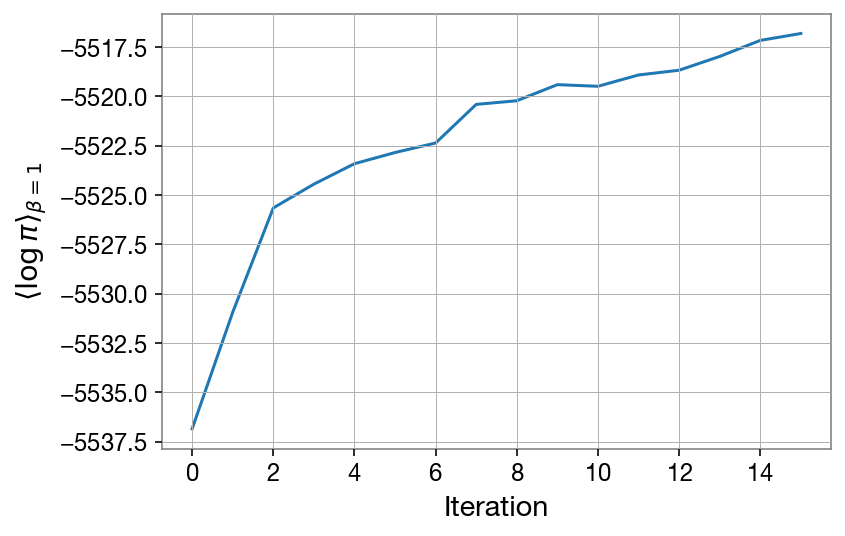

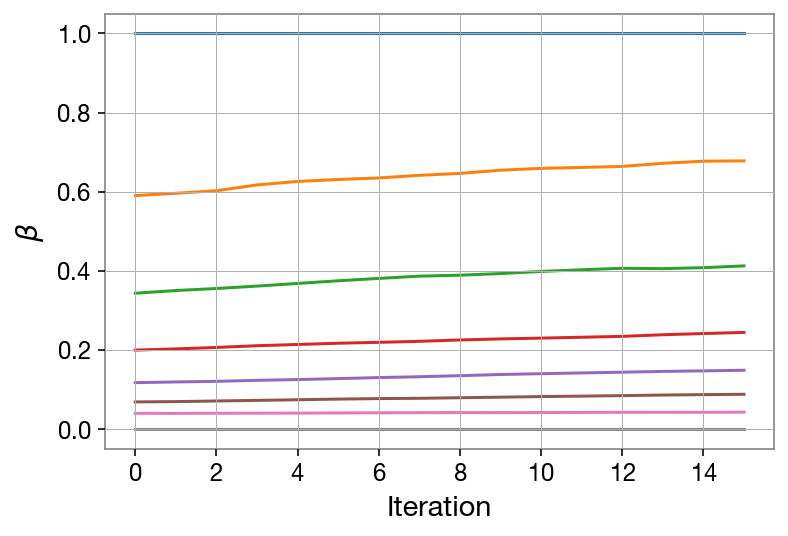

/Users/wfarr/miniconda3/envs/bilby/lib/python3.10/site-packages/arviz/data/base.py:220: UserWarning: More chains (64) than draws (16). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


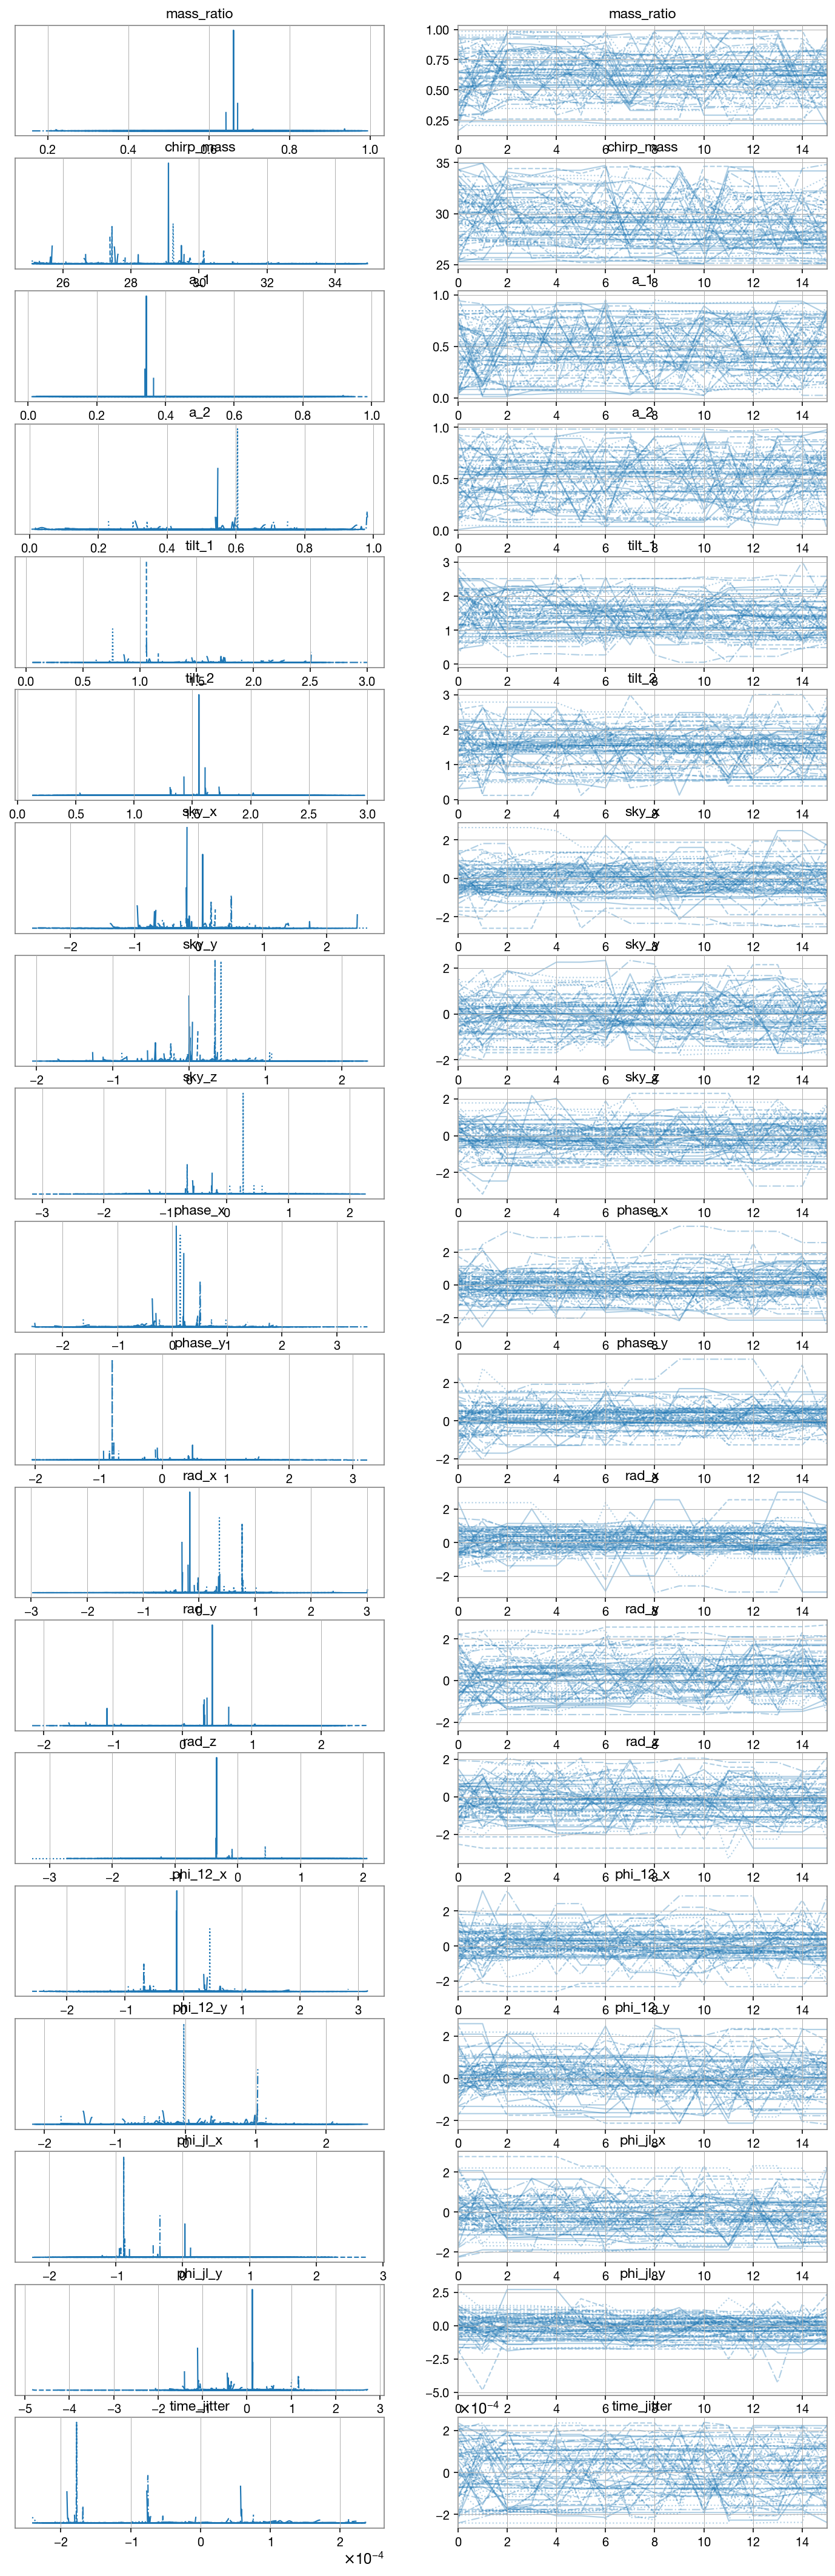

Looping with bad autocorrelation: 
The chain is shorter than 50 times the integrated autocorrelation time for 17 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [0.58020987 1.6437234  1.0752639  1.43957134 1.88467268
 0.12109198 1.10781695 0.18124757 0.85519141 1.95822406
 1.13522234 1.20144381 1.6131436  0.44648242 0.54520944
 1.42498491 1.03699787 1.7692441  0.68947396]


  0%|          | 0/32 [00:00<?, ?it/s]

Mean acceptance fraction:
[0.3828125  0.40625    0.39648438 0.390625   0.36914062
 0.37158203 0.36816406 0.3671875 ]

Mean tswap fraction:
[0.71435547 0.72509766 0.75048828 0.79736328 0.83349609
 0.82104492 0.77709961 0.74951172]


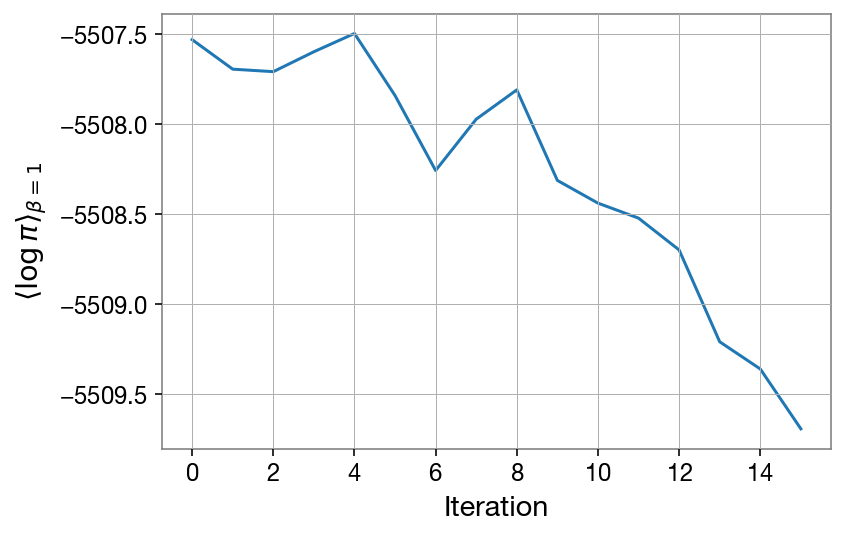

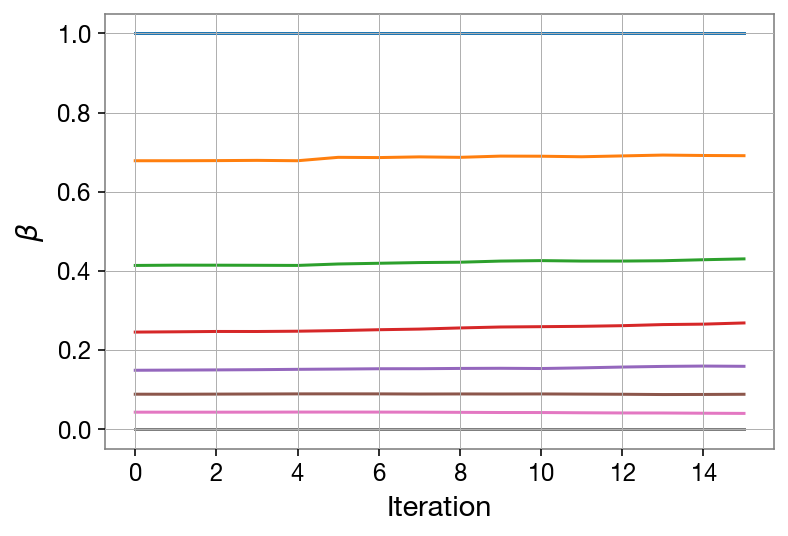

/Users/wfarr/miniconda3/envs/bilby/lib/python3.10/site-packages/arviz/data/base.py:220: UserWarning: More chains (64) than draws (16). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


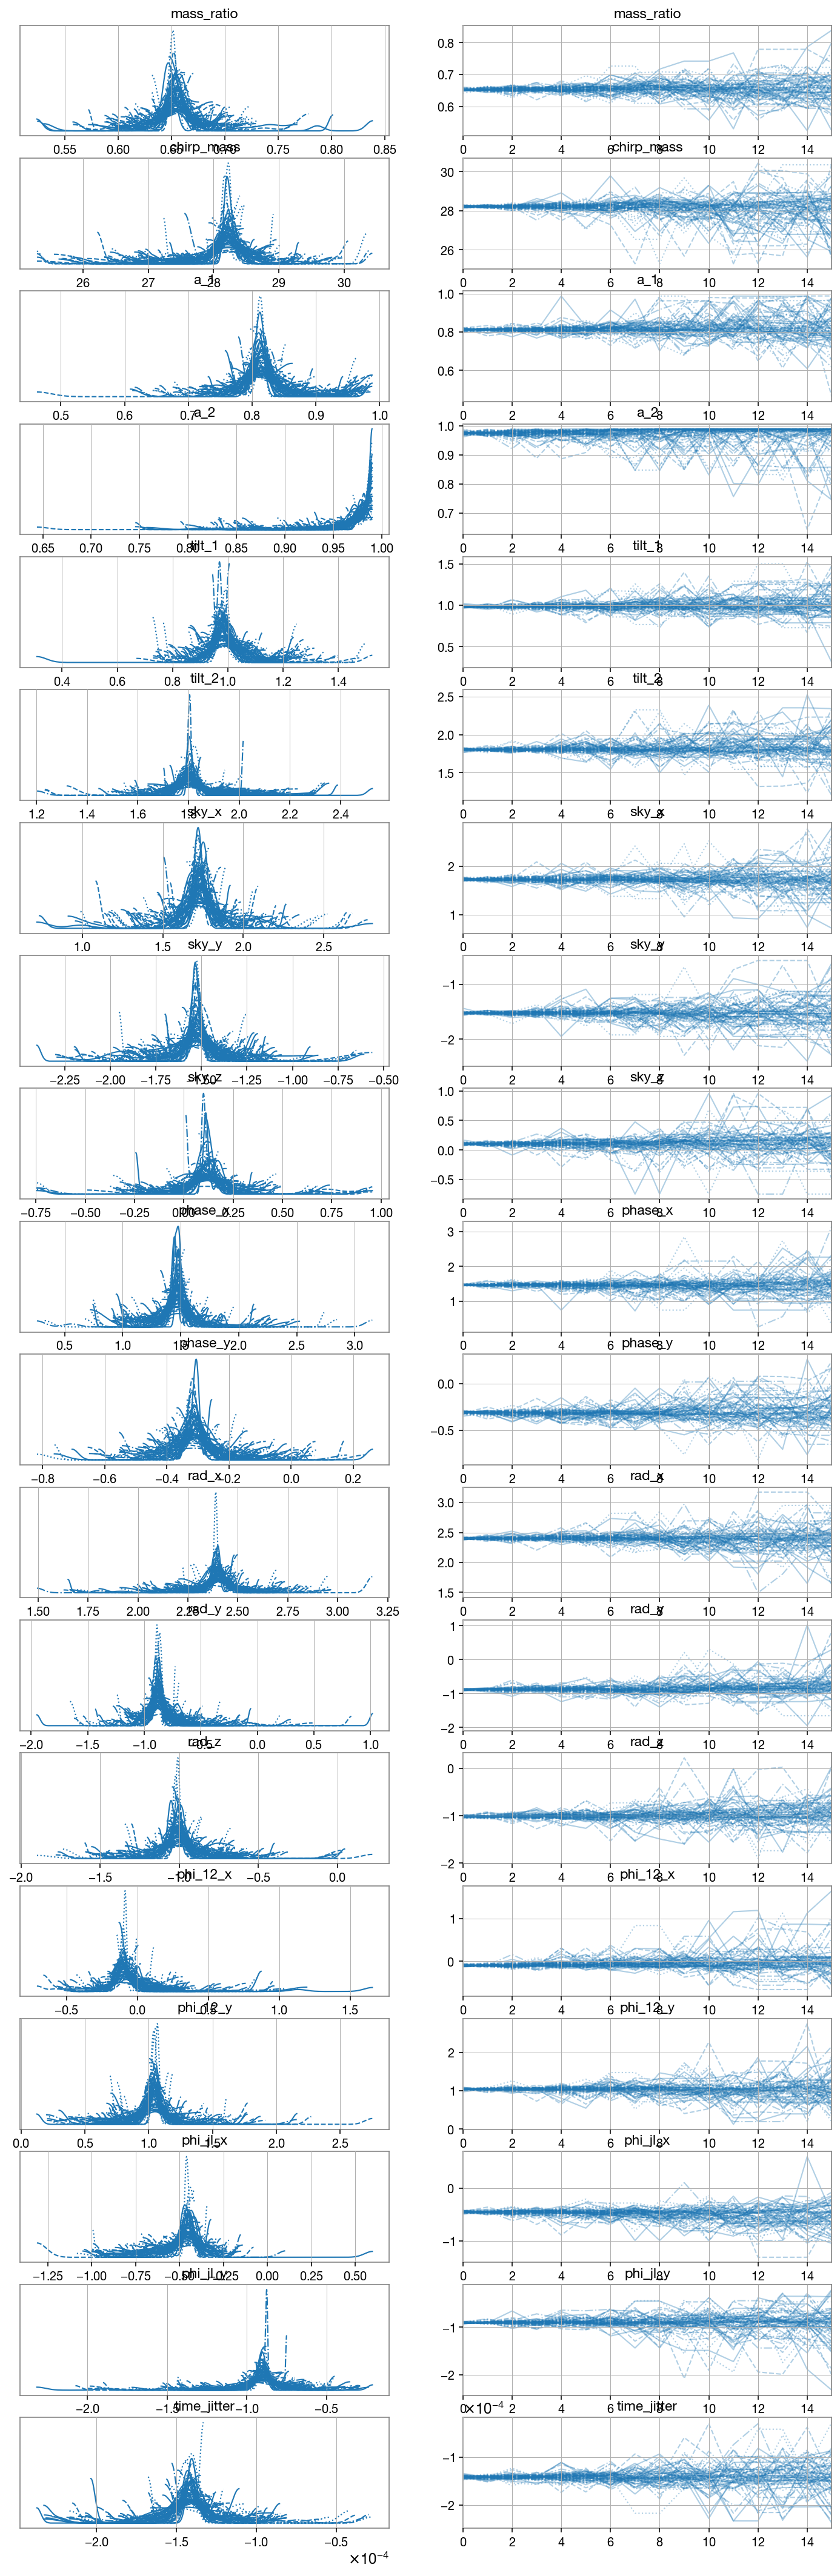

Looping with bad autocorrelation: 
The chain is shorter than 50 times the integrated autocorrelation time for 19 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [0.50784963 1.75285131 1.29595356 1.62246274 1.72526398
 1.38163554 0.33161333 0.69621191 0.58692706 0.83367851
 1.60179402 0.61474173 1.79145112 1.50344784 2.1118718
 0.75492162 2.01982707 1.22433488 0.38445238]


  0%|          | 0/64 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [43]:
while not converged:
    ptsampler.reset()
    thin = thin << 1
    for pos, log_post, log_like in tqdm(ptsampler.sample(pos, storechain=True, iterations=niter*thin, thin=thin, **sampler_kws), total=niter*thin):
        max_log_like = max(max_log_like, np.max(log_like))

    if max_log_like > old_max_log_like + significant_log_like:
        # Reset the sampler
        thin = 1
        old_max_log_like = max_log_like
        print('resetting sampler due to significant log-likelihood increase')

        # Cluster around the high-likelihood point
        cov = np.cov(pos[0,:,:], rowvar=False)
        bw = cov/1e2 # 10 times smaller
        pbest = pos[np.unravel_index(np.argmax(log_like), log_like.shape) + (None,)]

        pos = np.random.multivariate_normal(pbest.squeeze(), bw, size=log_like.shape)
        pos[0,0,:] = pbest.squeeze() # Ensure that the best point ends up in the sampler.

    
    print('Mean acceptance fraction:')
    print(np.mean(ptsampler.acceptance_fraction, axis=1))
    print()

    print('Mean tswap fraction:')
    print(ptsampler.tswap_acceptance_fraction)

    nt, nw, ns, nd = ptsampler.chain.shape

    plt.figure()
    plt.plot(np.arange(ns), np.mean(ptsampler.logprobability[0,:,:], axis=0))
    plt.xlabel(r'Iteration')
    plt.ylabel(r'$\left\langle \log \pi \right\rangle_{\beta = 1}$')
    plt.show()

    plt.figure()
    plt.plot(ptsampler.beta_history.T)
    plt.xlabel(r'Iteration')
    plt.ylabel(r'$\beta$')
    plt.show()

    idata = az.convert_to_inference_data({k: ptsampler.chain[0, :, :, i] for (i,k) in enumerate(sampler.search_parameter_keys)})
    az.to_netcdf(idata, 'checkpoint.nc')

    az.plot_trace(idata)
    plt.show()

    # The chain is (Ntemp, Nwalker, Nstep, Ndim), so we take the cold chain with
    # `[0,...]` then average over the number of walkers, then put in a "singleton"
    # walker dimension for emcee, which wants (Nstep, Nwalker, Ndim) inputs.
    try:
        avg_chain = np.mean(ptsampler.chain[0,...], axis=0)[:, None, :]
        taus = emcee.autocorr.integrated_time(avg_chain)
    except emcee.autocorr.AutocorrError as er:
        print('Looping with bad autocorrelation: ')
        print(er)
        continue
    converged = True
    break

## Sampling Loop End